In [3]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

import torchvision
import torchvision.models as tvm

from torchvision import transforms
from torchvision.datasets.folder import DatasetFolder,ImageFolder

import numpy as np
from glob import glob
from PIL import Image
import pandas as pd
import os,time,gc
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import datetime,random,string

ngpu=torch.cuda.device_count()
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("Using Pytorch Version : {} and Torchvision Version : {}. Using Device {}".format(torch.__version__,torchvision.__version__,device))

Using Pytorch Version : 1.4.0 and Torchvision Version : 0.5.0. Using Device cuda


In [4]:
from torch import nn
ngf=128
nz= latent_dim=10
e_lim = 10
nc=3 # Number of Channels

# Fixed Architecture: Weights will be updated by Backprop.
class AdveraryGenerator(nn.Module):
    def __init__(self,e_lim):
        super(AdveraryGenerator, self).__init__()
        self.e_lim = e_lim
        self.main = nn.Sequential(
        nn.ConvTranspose2d( in_channels=nz,out_channels= 1024, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(1024),
        nn.ReLU(True),
        # state size. (ngf*8) x 4 x 4
        nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # state size. (ngf*4) x 8 x 8
        nn.ConvTranspose2d( 512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # state size. (ngf*2) x 16 x 16
        nn.ConvTranspose2d(256, 128, 4, 2, 2, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # state size. (ngf) x 32 x 32
        nn.ConvTranspose2d( 128, 64, 4, 2, 2, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # state size. (nc) x 64 x 64
        nn.ConvTranspose2d( 64, 3, 4, 4,4, bias=False),
        nn.BatchNorm2d(3),
        nn.ReLU(True),
        nn.Tanh()
        )

    def forward(self, x):
        return self.e_lim * self.main(x) # Scaling of ε
    
    
adversarygen=AdveraryGenerator(e_lim).to(device)


In [1]:
PATH='/home/ubuntu/data/VGG16_Results/GeneratorW_vgg16_19_EEggLg.pth'

In [96]:
# Load Weights
adversarygen.load_state_dict(torch.load(PATH))
adversarygen.eval()

AdveraryGenerator(
  (main): Sequential(
    (0): ConvTranspose2d(10, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (13):

In [97]:
num_adv = 640
# latent_seed = 2 * torch.zeros(num_adv, nz, 1, 1, device=device,requires_grad=True) -1 # (r1 - r2) * torch.rand(a, b) + r2
latent_seed =  torch.zeros(num_adv, nz, 1, 1, device=device,requires_grad=True)


In [98]:
latent_seed.shape[1]

10

In [99]:
spaced=np.linspace(-1, 1, num=num_adv, endpoint=False)
for dim in range(latent_seed.shape[1]):
    latent_seed =  torch.zeros(num_adv, nz, 1, 1, device=device,requires_grad=True)
    latent_seed[:,dim,0,0]= torch.from_numpy(spaced)
    noise = adversarygen(latent_seed).permute(0,2,3,1).cpu().detach().numpy() *255/10
    create_video_frm_frames(noise,filename=f'Interpolating_Dimension-{dim}.mp4')

In [88]:
noise.shape, noise.mean(),noise.std()

((640, 224, 224, 3), 122.73443, 116.421844)

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
import cv2
def create_video_frm_frames(frames,filename='video.mp4'):
    height, width, layers = frames[0].shape
    size = (width,height)
    out = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    for i in range(len(frames)):
        out.write(frames[i].astype(np.uint8))
    out.release()

In [89]:
i=1

In [90]:
create_video_frm_frames(noise,filename=f'dim_{i}.mp4')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

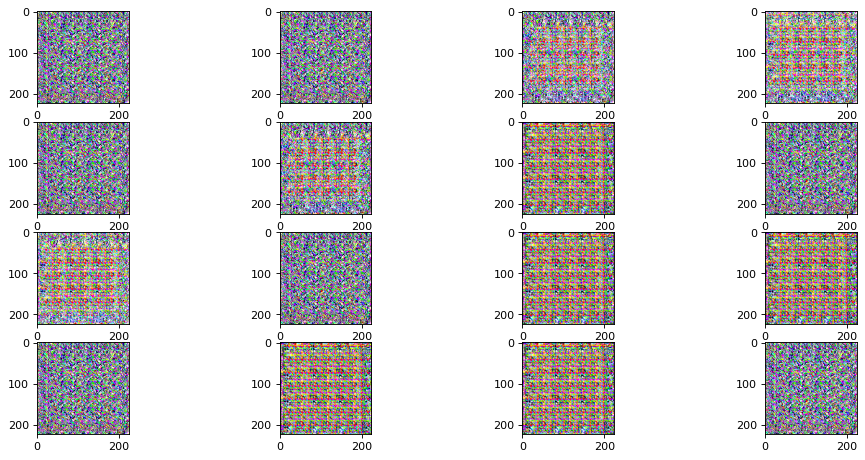

In [45]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(15, 7), dpi=80)
n=0
for row in ax:
    for col in row:
        img = noise[n,:]
        n+=1
        col.imshow(img)